In [11]:
import torch
import my_config
from my_dataset import CropDataset
from model import get_model
import torchvision
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from my_utils import train_one_epoch
from pycocotools.cocoeval import COCOeval
from my_utils import infer_on_dataset, convert_to_coco_api, collate_fn

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
torch.cuda.empty_cache()

In [3]:
print("Torch version:", torch.__version__)



print('Preparing datasets')

# Training dataset & loader
train_dataset = CropDataset(my_config.image_path,my_config.annotatio_path,
                            crop_size=my_config.crop_size, stride=my_config.stride,
                            dataset='train',split_direction=my_config.split_direction,
                            splits = my_config.splits)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=my_config.train_batch_size,
                                               shuffle=my_config.train_shuffle_dl,
                                               num_workers=my_config.num_workers_dl,
                                               collate_fn=collate_fn)

# Validation dataset & loader
validation_dataset = CropDataset(my_config.image_path,my_config.annotatio_path,
                                 crop_size=my_config.crop_size, stride=my_config.stride,
                                 dataset='validation',split_direction=my_config.split_direction,
                                 splits = my_config.splits)

validation_dataloader = torch.utils.data.DataLoader(validation_dataset,
                                             batch_size=1,
                                             shuffle= False,
                                             num_workers=1,
                                             collate_fn=collate_fn)

# create COCO API object for evaluation later
coco_gt =convert_to_coco_api(validation_dataset)

# add segmentation data overlapping the bboxes (requiered for drawing, not part of the training data)
for ii, ann in enumerate(coco_gt.anns.items()):
    bb = ann[1]['bbox']
    x1, x2, y1, y2 = [bb[0], bb[0] + bb[2], bb[1], bb[1] + bb[3]]
    if 'segmentation' not in ann:
        ann[1]['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]


print('Datasets ready')


# select device (whether GPU or CPU)

device = torch.device("cuda") if torch.cuda.is_available() and my_config.use_cuda else torch.device("cpu")

print(f'Using device: {device}')

print('Loading model')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, my_config.num_classes)
# move model to the right device

model.to(device)
print('Model loaded')

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=my_config.lr, momentum=my_config.momentum, weight_decay=my_config.weight_decay
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=my_config.scheduler_step,
                                               gamma=my_config.scheduler_gamma)

Torch version: 1.2.0
Preparing datasets
creating index...
index created!
Datasets ready
Using device: cuda
Loading model
Model loaded


In [4]:
print('Training...')
len_dataloader = len(train_dataloader)
for epoch in range(my_config.num_epochs):
    print(f"Epoch: {epoch}/{my_config.num_epochs}")
    train_one_epoch(model,optimizer,train_dataloader,device,my_config.print_freq)
    print(f"Evaluating...")
    results = infer_on_dataset(model,validation_dataloader,device,my_config.print_freq,True)
    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt,coco_dt,iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
torch.cuda.empty_cache()

Training...
Epoch: 0/3
(4/38) loss: combined=6.083; classifier=2.051; box_reg=2.398; objectness=1.271; rpn_box_reg=0.362
(8/38) loss: combined=4.460; classifier=1.696; box_reg=1.934; objectness=0.526; rpn_box_reg=0.304
(12/38) loss: combined=5.450; classifier=1.858; box_reg=1.727; objectness=1.281; rpn_box_reg=0.584
(16/38) loss: combined=4.626; classifier=1.807; box_reg=1.730; objectness=0.613; rpn_box_reg=0.476
(20/38) loss: combined=3.723; classifier=1.461; box_reg=1.404; objectness=0.497; rpn_box_reg=0.361
(24/38) loss: combined=3.146; classifier=1.338; box_reg=1.064; objectness=0.445; rpn_box_reg=0.299
(28/38) loss: combined=2.940; classifier=1.207; box_reg=1.024; objectness=0.395; rpn_box_reg=0.314
(32/38) loss: combined=2.901; classifier=1.140; box_reg=1.060; objectness=0.368; rpn_box_reg=0.333
(36/38) loss: combined=2.808; classifier=1.273; box_reg=0.991; objectness=0.259; rpn_box_reg=0.286
Evaluating...
(4/19)
(8/19)
(12/19)
(16/19)
Loading and preparing results...
DONE (t=0.0

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.789
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

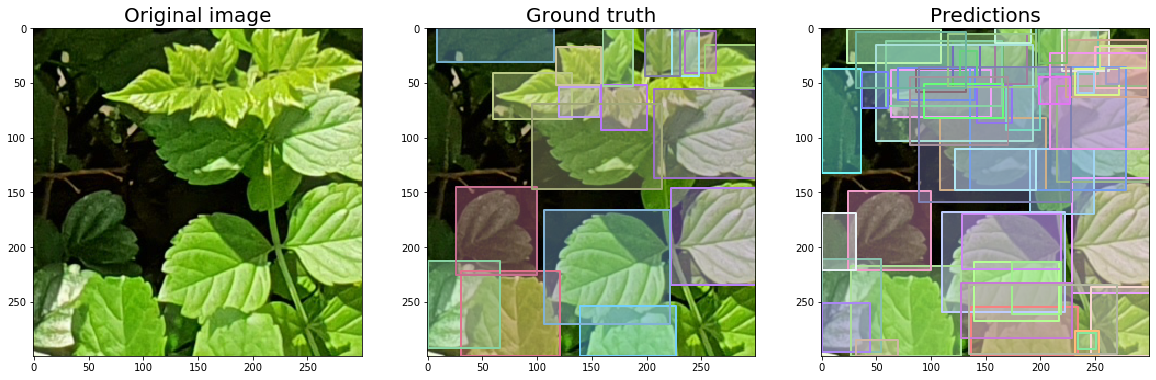

In [21]:
image_to_show = 10

f,ax = plt.subplots(1,3,figsize=(20,10))
ax = ax.ravel()
temp = Image.fromarray(validation_dataset[image_to_show][0].mul(255).permute(1, 2, 0).byte().numpy())
ax[0].imshow(temp)
ax[1].imshow(temp)
ax[2].imshow(temp)

plt.sca(ax[0])
plt.title("Original image", fontsize=20)


plt.sca(ax[1])
plt.title("Ground truth", fontsize=20)
coco_gt.showAnns(coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=[image_to_show])))

plt.sca(ax[2])
plt.title("Predictions", fontsize=20)
coco_dt.showAnns(coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=[image_to_show])))


coco_eval.params.imgIds=[image_to_show]
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

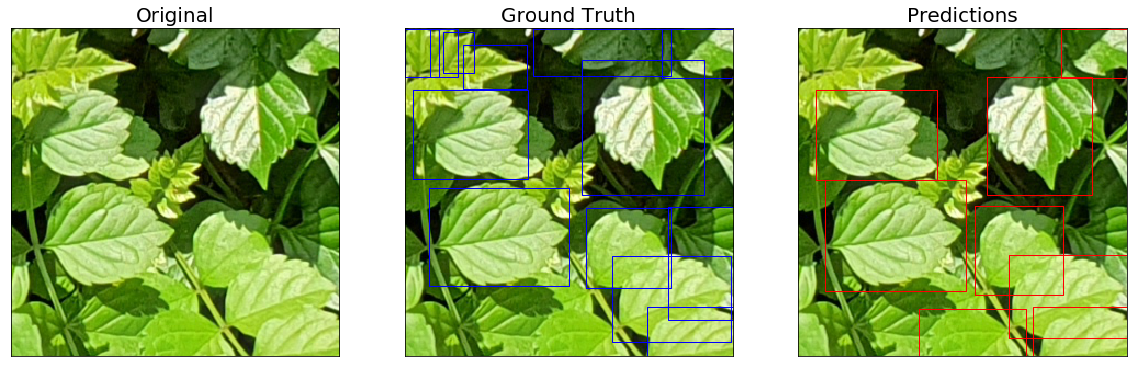

Text(0.5, 1.0, 'Predictions')

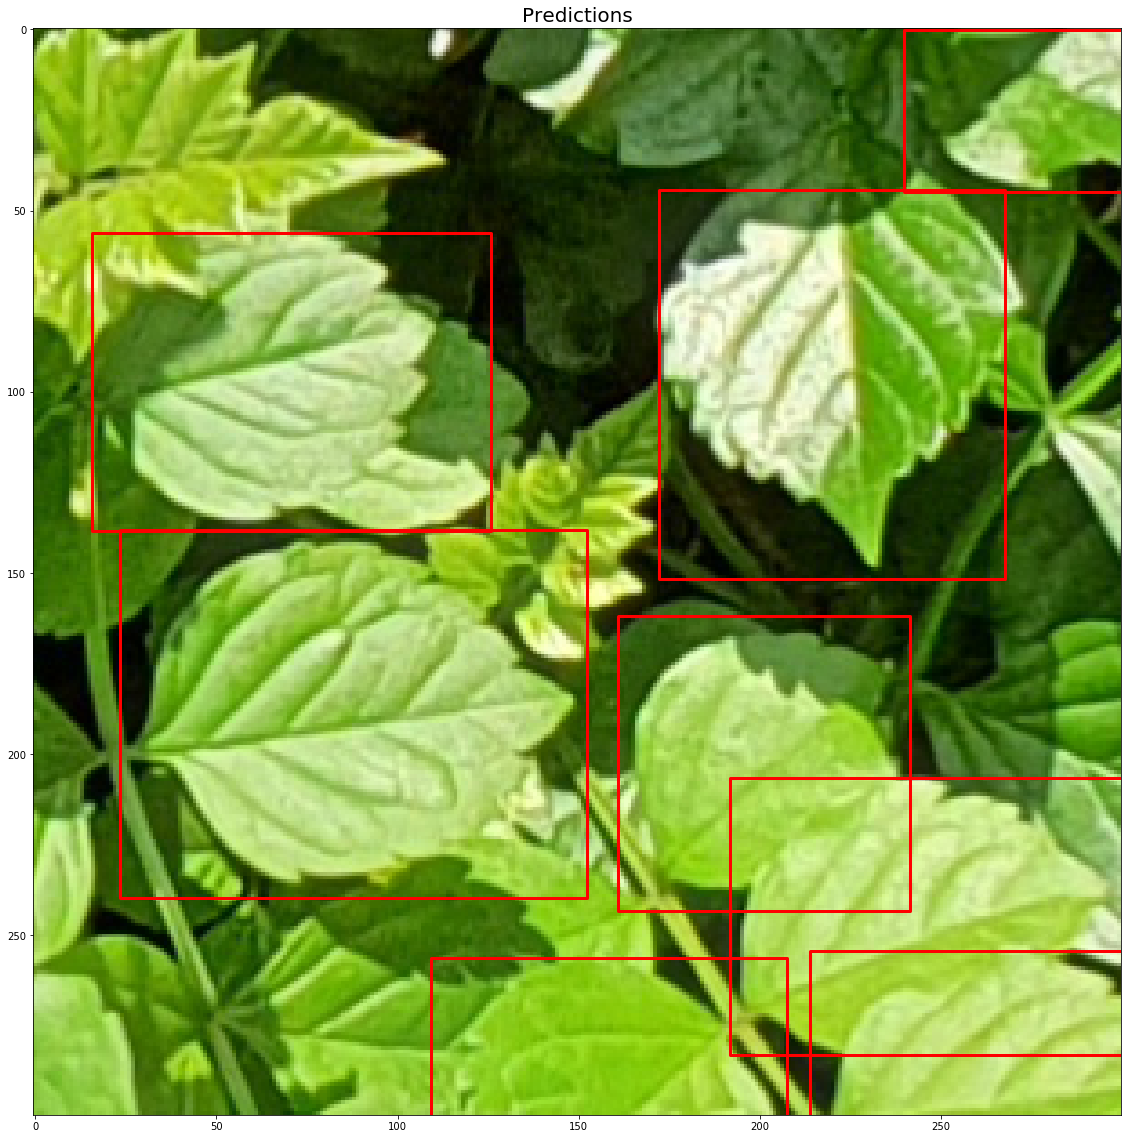

In [23]:
min_confidence = .95
image_to_show = 11

# pick one image from the test set
img, gt = validation_dataset[image_to_show]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    predictions = model([img.to(device)])
boxes = predictions[0]['boxes'].to('cpu')
scores = predictions[0]['scores'].to('cpu')

f,ax = plt.subplots(1,3,figsize=(20,10))

temp = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
ax[0].imshow(temp)
ax[1].imshow(temp)
ax[2].imshow(temp)
for m_ax in ax:
    m_ax.xaxis.set_major_locator(plt.NullLocator())
    m_ax.yaxis.set_major_locator(plt.NullLocator())
p=[]
for score,box in zip(scores,boxes):
    if score >min_confidence:
        p.append(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1]))
ax[2].add_collection(PatchCollection(p,linewidth=1,edgecolor='r',facecolor='none'))

p=[]
for gt_box in gt['boxes']:
    p.append(Rectangle((gt_box[0],gt_box[1]),gt_box[2]-gt_box[0],gt_box[3]-gt_box[1]))
ax[1].add_collection(PatchCollection(p,linewidth=1,edgecolor='b',facecolor='none'));

ax[0].set_title('Original',fontsize=20)
ax[1].set_title('Ground Truth',fontsize=20)
ax[2].set_title('Predictions',fontsize=20)

plt.show()

f, ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(temp)
p=[]
for score,box in zip(scores,boxes):
    if score >min_confidence:
        p.append(Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1]))
ax.add_collection(PatchCollection(p,linewidth=3,edgecolor='r',facecolor='none'))
ax.set_title('Predictions',fontsize=20)